In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import SPSA, COBYLA, ADAM
from qiskit.primitives import Sampler
from qiskit_aer import Aer  # Import corrigido para Aer
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from vqc_lite.circuit_stack_pennylane.circuit_mps import MPS_GU2_P
from vqc_lite.experiments.expressibility import Expressibility_Evaluation
from vqc_lite.experiments.state_preparation import Compression_Adam
import gc 



In [2]:
path = 'dos_data_attck.csv'

# **Funções Utils**

In [3]:
def plot_distribution(datas):
  fig = px.bar(
      datas.groupby('Label').size().reset_index(name='Count'),
      y='Label',
      x='Count',
      orientation='h',
      color_discrete_sequence=px.colors.qualitative.Dark2
  )

  fig.update_layout(
      title={
          'text': '<b>Distribuição de Labels</b>',
          'x': 0.5,  # Centralizar o título horizontalmente
          'xanchor': 'center',
          'yanchor': 'top'
      },
      showlegend=False,
      xaxis_title='Quantidade',
      yaxis_title='Label'
  )

  fig.update_yaxes(
      showgrid=False,
      showline=True,
      linewidth=2,
      linecolor='black'
  )
  fig.update_xaxes(
      showgrid=False,
      showline=True,
      linewidth=2,
      linecolor='black'
  )
  fig.show()

In [4]:

def dataset_transform(
    path, 
    drop_colunms=['Timestamp', 'Can_Interface', 'CAN_ID'],
    classify_to_binary=False, 
    escalation=False,
    samples_per_class=None  # Novo parâmetro para definir a quantidade de amostras por classe
):
    scaler = StandardScaler()  # Instancia o StandardScaler
    columns = ['Timestamp', 'Can_Interface', 'CAN_ID', 'Message', 'Label']
    datas = pd.read_csv(path, sep=' ', names=columns, engine='python')
    datas = datas.drop(drop_colunms, axis=1)

    # Substituir 'benign' por 0 e outras labels por 1
    if classify_to_binary:
        datas['Label'] = datas['Label'].apply(lambda x: 0 if x == 'benign' else 1)

    # Selecionar um número específico de amostras por classe
    if samples_per_class:
        sampled_data = []
        for label, count in samples_per_class.items():
            class_data = datas[datas['Label'] == label]
            sampled_class = class_data.sample(n=count, replace=len(class_data) < count, random_state=42)
            sampled_data.append(sampled_class)
        datas = pd.concat(sampled_data).reset_index(drop=True)

    # Completar as mensagens com zeros à direita se forem menores que 16 caracteres (8 bytes)
    datas['Message'] = datas['Message'].apply(lambda x: x.ljust(16, '0') if len(x) < 16 else x)

    # Converter cada byte de cada mensagem CAN para seu valor decimal
    data_array = datas['Message'].values
    target = datas['Label'].values

    data_transform = []
    for data in data_array:
        numeric_values = [int(data[i:i + 2], 16) for i in range(0, len(data), 2)]
        data_transform.append(numeric_values)

    if escalation:
        data_transform = scaler.fit_transform(data_transform)  # Aplica o fit_transform aos valores do DataFrame

    data_transform = np.array(data_transform)
    return datas, data_transform, target


In [5]:
# Função de treinamento com 10-fold
def train_vqc(data, labels, layers=1, optimizer='adam', epochs=10, num_qubits=4):
    # Inicializar o circuito VQC com as camadas e qubits especificados
    circuit = MPS_GU2_P(nl=layers, nq=num_qubits)

    # Número de parâmetros (ajustar conforme necessário)
    num_params = layers * num_qubits * 15  # Ajuste conforme a definição do circuito

    # Treinamento 10-fold
    kf = KFold(n_splits=10)
    accuracies = []

    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Parâmetros iniciais para o circuito
        params = np.random.uniform(size=num_params)
        params = circuit.params_to_proper_shape(params)

        # Treinamento com Compression_Adam para cada amostra
        accuracies_fold = []
        for x, y in zip(X_train, y_train):
            # Ajustar o formato da entrada x para ser compatível com a estrutura do circuito
            # Redimensionar o vetor para a dimensão esperada de 2^num_qubits (16 para 4 qubits)
            x_reshaped = np.zeros(2**num_qubits)
            x_reshaped[:len(x)] = x  # Preencher os primeiros elementos do vetor com os dados de entrada

            # Normalizar o vetor de entrada para ser um vetor de estado válido
            norm = np.linalg.norm(x_reshaped)
            if norm == 0:
                x_reshaped[0] = 1 / np.sqrt(2)  # Definir como um estado base se a norma for zero
                x_reshaped[-1] = 1 / np.sqrt(2)  # Para simular um estado GHZ
            else:
                x_reshaped /= norm

            # Ajustar a forma do vetor para ser compatível com o GHZ de 4 qubits
            ghz = x_reshaped.reshape((2, 2, 2, 2))

            # Usar Compression_Adam para o treinamento
            if optimizer == 'adam':
                task = Compression_Adam(ghz, circuit, steps=epochs)
                task.run()

            # Obter a saída do circuito e calcular a predição
            psi_out = circuit.run_with_param_input(params)

            # Calculando a predição (simplificadamente usando a posição de maior probabilidade)
            prediction = np.argmax(np.abs(psi_out)**2)
            accuracies_fold.append(int(prediction == y))

        # Calcular a acurácia da fold atual
        accuracy = np.mean(accuracies_fold)
        accuracies.append(accuracy)

    return np.mean(accuracies), np.std(accuracies)


In [6]:
def angle_embedding(data):
    """
    Converte os dados em ângulos de rotação para um circuito quântico.
    Aplica rotação R_y(theta) para cada valor no array de entrada.
    
    Parâmetros:
    - data: array numpy de forma (n amostras, d features)
    
    Retorno:
    - circuit: QuantumCircuit com rotações de acordo com os dados
    """
    n_samples, n_features = data.shape
    n_qubits = n_features  # Cada feature será embutida em um qubit

    # Criação do circuito quântico
    circuit = QuantumCircuit(n_qubits)

    # Itera sobre as amostras e aplica rotações nas features
    for i in range(n_features):
        # Normaliza os dados para [0, pi] para garantir que sejam ângulos válidos
        theta = np.interp(data[:, i], (data[:, i].min(), data[:, i].max()), (0, np.pi))
        
        # Aplica a rotação R_y para o qubit correspondente
        circuit.ry(theta[0], i)  # Supondo que usamos apenas a primeira amostra para demonstração

    return circuit


In [7]:
# Função para plotar gráficos de acurácia e loss por fold
def plot_results(accuracies, losses):
    folds = np.arange(1, len(accuracies) + 1)

    # Gráfico de acurácia por fold
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(folds, accuracies, marker='o', linestyle='-', color='blue', label='Accuracy')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Fold')
    plt.legend()
    plt.grid(True)

    # Gráfico de loss por fold
    plt.subplot(1, 2, 2)
    plt.plot(folds, losses, marker='o', linestyle='-', color='red', label='Loss')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.title('Loss per Fold')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [8]:
# Backend global reutilizável
backend = Aer.get_backend('qasm_simulator')

def create_quantum_instance(shots=1024):
    """Cria uma instância de sampler com backend fixo."""
    options = {"backend": backend, "shots": shots}
    return Sampler(options=options)

def create_ansatz(num_qubits, ansatz_type='RealAmplitudes', num_layers=2):
    """Cria o circuito ansatz."""
    if ansatz_type == 'RealAmplitudes':
        return RealAmplitudes(num_qubits, reps=num_layers)
    elif ansatz_type == 'EfficientSU2':
        return EfficientSU2(num_qubits, reps=num_layers)
    else:
        raise ValueError("Tipo de ansatz não suportado.")

def create_feature_map(data_point, num_qubits, embedding='amplitude'):
    """Cria o circuito de feature map com o tipo de embedding desejado."""
    feature_map = QuantumCircuit(num_qubits, num_qubits)

    if embedding == 'amplitude':
        state_vector = np.zeros(2 ** num_qubits)
        state_vector[:len(data_point)] = data_point
        state_vector /= np.linalg.norm(state_vector)
        feature_map.initialize(state_vector, range(num_qubits))

    elif embedding == 'phase':
        for i in range(num_qubits):
            feature_map.ry(data_point[i], i)

    else:
        raise ValueError("Tipo de embedding não suportado.")

    feature_map.measure(range(num_qubits), range(num_qubits))
    return feature_map

def train_vqc(data, labels, num_qubits, ansatz_type='RealAmplitudes', embedding='amplitude',
              optimizer='COBYLA', epochs=50, num_layers=2, quantum_instance=None):
    """Treina o modelo VQC com K-Fold, retorna a tabela de acurácias e plota loss vs accuracy."""
    ansatz = create_ansatz(num_qubits, ansatz_type, num_layers)
    sampler = create_quantum_instance()
    kf = KFold(n_splits=5)
    accuracies = []
    losses = []
    results_df = pd.DataFrame(columns=['Fold', 'Accuracy', 'Optimizer', 'Embedding'])

    fold_index = 1
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        vqc = VQC(ansatz=ansatz, optimizer=optimizer, sampler=sampler)
        vqc.fit(X_train, y_train)

        y_pred = []
        y_pred_probs = []
        for x in X_test:
            feature_map_circuit = create_feature_map(x, num_qubits, embedding)
            result = sampler.run(feature_map_circuit).result()
            counts = result.quasi_dists[0].binary_probabilities()
            
          # Normaliza as probabilidades
            total_count = sum(counts.values())
            prob_0 = counts.get('0', 0) / total_count
            prob_1 = counts.get('1', 0) / total_count

            prediction = 1 if prob_1 > prob_0 else 0
            y_pred.append(prediction)
            y_pred_probs.append([prob_0, prob_1])

            del feature_map_circuit, result
            gc.collect()

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        # Cálculo da loss (entropia cruzada)
        loss = log_loss(y_test, y_pred_probs, labels=[0, 1])
        losses.append(loss)

        results_df = pd.concat([results_df, pd.DataFrame({
            'Fold': [fold_index],
            'Accuracy': [accuracy],
            'Optimizer': [optimizer],
            'Embedding': [embedding]
        })], ignore_index=True)

        # Imprime o circuito ansatz
        print(f"Circuito do Ansatz - Fold {fold_index}:")
        print(ansatz)
        fold_index += 1

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    return accuracies, std_accuracy, losses, results_df

# Exemplo de execução
def execute_training_pipeline(data, labels, num_samples=100, num_qubits=8, ansatz_choice='RealAmplitudes',
                              embedding_type='amplitude', optimizer='COBYLA'):
    print('Iniciando pipeline de treinamento...')
    data_subset = np.concatenate((data[:num_samples], data[-num_samples:]))
    labels_subset = np.concatenate((labels[:num_samples], labels[-num_samples:]))

    accuracy_amplitude, std_amplitude, losses, results_df_amp = train_vqc(
        data_subset, labels_subset, num_qubits, ansatz_choice, 'amplitude', optimizer, 25, 2
    )
    print(f"Resultados para o embedding Amplitude:\n{results_df_amp}\n")

    accuracy_phase, std_phase, losses, results_df_phase = train_vqc(
        data_subset, labels_subset, num_qubits, ansatz_choice, 'phase', optimizer, 25, 2
    )
    print(f"Resultados para o embedding Phase:\n{results_df_phase}\n")

    print(f"Accuracy (Amplitude Embedding): {np.mean(accuracy_amplitude):.4f} ± {std_amplitude:.4f}")
    print(f"Accuracy (Phase Embedding): {np.mean(accuracy_phase):.4f} ± {std_phase:.4f}")

    plot_results(accuracy_amplitude, losses)


# **Define train and test split**

In [9]:
datas, data_transform, target = dataset_transform(path,  classify_to_binary=True, escalation=True,samples_per_class={0: 500, 1: 500})

In [10]:
datas

,Message,Label
0,FFFFFF0000000000,0
1,0201435555555555,0
2,02018D5555555555,0
3,FFFFFF0000000000,0
4,0201B45555555555,0
...,...,...
995,0000000000000000,1
996,0000000000000000,1
997,0000000000000000,1
998,0000000000000000,1


In [11]:
plot_distribution(datas)

/home/rsb6/Desktop/Quantica/.venv-qiskit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2956: UserWarning:

The y_pred values do not sum to one. Make sure to pass probabilities.



Circuito do Ansatz - Fold 5:
     »
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
q_6: »
     »
q_7: »
     »
«     ┌────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                       ├
«     │                                                                                                                                                        │
«q_1: ┤1                                                                                                                                                       ├
«     │                                                                                                                                                        │
«q_2: ┤2                                       

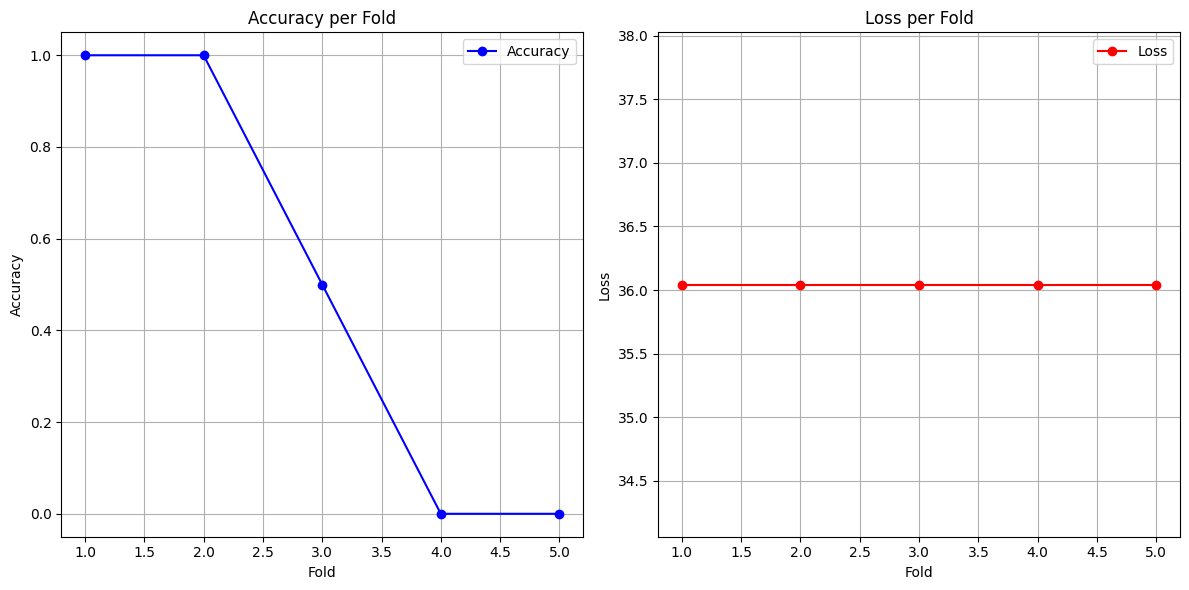

In [12]:
# Executar o pipeline de treinamento
execute_training_pipeline(
    data_transform, target,           # Dados e rótulos
    num_qubits=8,                     # Número de qubits
    num_samples=20,                   # Número de amostras de dados
    ansatz_choice='RealAmplitudes',   # Tipo de ansatz ('RealAmplitudes' ou 'EfficientSU2')
    embedding_type='amplitude',       # Tipo de embedding ('amplitude' ou 'phase')
    optimizer=ADAM(maxiter=20)        # Otimizador (COBYLA, SPSA, ADAM, etc.)
)